# Coherent vs Incoherent de-dispersion
This is a small playground for me to experiment with two methods for de-dispersing signals (e.g. FRBs or pulsars).
This will be based on discussions in the Handbook of Pulsar Astronomy (Lorimer & Kramer, 2012).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sgnl
from log_progress import log_progress

In [2]:
# Some physics
dispersion_constant = 4.1488e3  # MHz^2 pc^-1 cm^3 s
dispersion_constant2 = dispersion_constant * 1e6  # MHz pc^-1 cm^3 (Note non-conventional units)

In [3]:
# Set up "observing" parameters
f0 = 1420.0  # MHz
bandwidth = 200.0  # MHz
dt = 1.0 / (bandwidth * 1e6)
obs_time = 1.0e-2  # s
t_axis = np.arange(0, obs_time, dt)

In [4]:
# Create our simulated pulse
signal_level = 1.0  # Arbitrary units (volts?)
signal_time = obs_time / 2.0
signal_ind = np.argmin(np.abs(t_axis - signal_time))
signal_width = obs_time / 100000.0
DM = 10.0  # pc cm^-3
noise_level = 0.001

# signal_in = np.complex64(signal_level * np.exp(-(t_axis - signal_time)**2 / (2 * signal_width**2)))
signal_in = np.zeros(t_axis.shape, dtype=np.complex64)
signal_in[signal_ind] = signal_level
signal_in += noise_level * (np.random.randn(signal_in.shape[0]) + 1j * np.random.randn(signal_in.shape[0]))

In [5]:
# Go to frequency space to disperse the signal
f_signal = np.fft.fftshift(np.fft.fft(signal_in))
df = 1.0 / obs_time * 1e-6  # MHz
f_axis = df * np.arange(t_axis.shape[0], dtype=np.float64) - bandwidth / 2.0
H = np.exp(1j * 2 * np.pi * dispersion_constant2 * DM * f_axis**2 / ((f_axis + f0) * f0**2))
f_signal *= H
signal = np.fft.ifft(np.fft.ifftshift(f_signal))

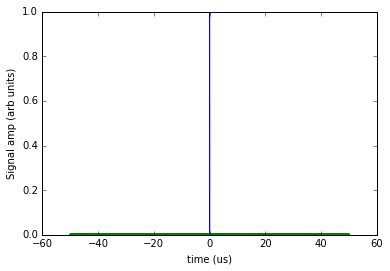

In [6]:
plt.plot(1e6 * (t_axis[(signal_ind - 10000):(signal_ind + 10000)] - signal_time), np.abs(signal_in[(signal_ind - 10000):(signal_ind + 10000)]))
plt.plot(1e6 * (t_axis[(signal_ind - 10000):(signal_ind + 10000)] - signal_time), np.abs(signal[(signal_ind - 10000):(signal_ind + 10000)]))
plt.xlabel('time (us)'); plt.ylabel('Signal amp (arb units)');

In [7]:
# Break signal up into time chunks
n_t_chunks = np.int(np.floor(np.sqrt(t_axis.shape[0])))  # roughly same freq as t
n_t_per_chunk = n_t_chunks
# Drop any trailing data taht doesn't fit the square
t_data = signal[0:(n_t_chunks * n_t_per_chunk)].reshape((n_t_chunks, n_t_per_chunk))

# Do FT
window = sgnl.blackmanharris(n_t_per_chunk)
f_data = np.abs(np.fft.fftshift(np.fft.fft(window * t_data, axis=1), axes=1))**2
t_axis_coarse = t_axis[(n_t_per_chunk / 2)::n_t_per_chunk]
dt_coarse = dt * n_t_per_chunk
df_coarse = df * n_t_per_chunk
f_axis_coarse = df_coarse * np.arange(n_t_per_chunk - 1, dtype=np.float64) - bandwidth / 2.0

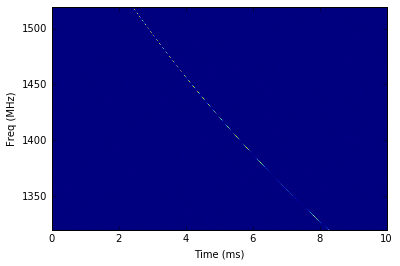

In [8]:
plt.imshow(np.abs(f_data.transpose()), origin='lower',
           extent=(1e3 * t_axis_coarse.min(), 1e3 * t_axis_coarse.max(), f_axis_coarse.min() + f0, f_axis_coarse.max() + f0),
           aspect='auto')
plt.xlabel('Time (ms)'); plt.ylabel('Freq (MHz)');

In [9]:
# Brute force a dispersion measure transform
# Set up axes
delta_t_max = t_axis_coarse.max() - t_axis_coarse.min()
DM_max = delta_t_max / (dispersion_constant * ((f_axis_coarse.min() + f0)**-2 - (f_axis_coarse.max() + f0)**-2))
DM_axis = np.arange(n_t_per_chunk) * DM_max / n_t_per_chunk
DM_mat = np.zeros((n_t_per_chunk, n_t_chunks))

# Need to rewrite... takes wayyyy too long
# Also, I'm pretty sure it's buggy.
fsq_axis = dispersion_constant * (f_axis_coarse**-2 - f_axis_coarse[-1]**-2)
t_min = t_axis_coarse.min()
for ti, t0 in enumerate(log_progress(t_axis_coarse, every=10)):
    for dmi, dm in enumerate(DM_axis):
        for fi, f in reversed(list(enumerate(fsq_axis))):
            # ind = np.argmin(np.abs(t_axis_coarse - dm * fsq_axis))
            ind = np.int(np.round((t0 + dm * f - t_min) / dt_coarse))
            if ind >= n_t_chunks:
                break
            DM_mat[ti, dmi] += f_data[ind, fi]